In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm, skew
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ml-dataset/train.csv
/kaggle/input/ml-dataset/test.csv
/kaggle/input/ml-dataset/sample_submission.csv
/kaggle/input/fare-classification/meta_data.csv


In [2]:
train = pd.read_csv("../input/ml-dataset/train.csv")
test = pd.read_csv("../input/ml-dataset/test.csv")
IDtest = test["tripid"]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  obj

In [4]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [5]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [6]:
Outliers_to_drop = detect_outliers(train,2,["additional_fare","duration","meter_waiting","meter_waiting_fare","meter_waiting_till_pickup"
                                           ,"pick_lat","pick_lon","drop_lat","drop_lon"])

In [7]:
train.loc[Outliers_to_drop]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
25,189160756,10.5,358.0,66.0,0.0000,79.0,11/1/2019 8:51,11/1/2019 8:57,6.05858,80.2003,6.05566,80.1810,210.58,incorrect
34,189164791,10.5,286.0,44.0,0.0000,9.0,11/1/2019 9:23,11/1/2019 9:28,7.48628,80.6206,7.47984,80.6233,545.89,incorrect
51,189182800,10.5,220.0,10.0,0.0000,27.0,11/1/2019 11:34,11/1/2019 11:37,7.48995,80.3639,7.49838,80.3715,71.84,correct
84,189227008,10.5,2159.0,1158.0,67.5114,344.0,11/1/2019 14:31,11/1/2019 15:07,7.32514,80.6521,7.29959,80.6366,274.56,correct
115,189250944,10.5,1301.0,10.0,0.0000,60.0,11/1/2019 16:43,11/1/2019 17:05,7.31738,80.6995,7.33181,80.6289,356.51,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16751,213125070,10.5,1748.0,80.0,0.0000,37.0,1/29/2020 20:42,1/29/2020 21:11,7.29311,80.6370,7.33452,80.6823,431.96,correct
16944,213372335,10.5,300.0,1.0,0.0583,66.0,1/30/2020 17:48,1/30/2020 17:53,7.30790,80.6371,7.32106,80.6387,99.53,correct
16966,213397557,30.5,777.0,54.0,0.0000,128.0,1/30/2020 18:53,1/30/2020 19:06,7.29334,80.6361,7.32462,80.6355,239.43,correct
17037,213521569,10.5,659.0,40.0,0.0000,87.0,1/31/2020 10:39,1/31/2020 10:50,7.29424,80.6335,7.32501,80.6311,177.47,correct


In [8]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [9]:
train.shape

(15958, 14)

In [10]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [11]:
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

tripid                          0
additional_fare               183
duration                      183
meter_waiting                 183
meter_waiting_fare            183
meter_waiting_till_pickup     183
pickup_time                     0
drop_time                       0
pick_lat                        0
pick_lon                        0
drop_lat                        0
drop_lon                        0
fare                          129
label                        8576
dtype: int64

In [12]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15958 entries, 0 to 15957
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     15958 non-null  int64  
 1   additional_fare            15775 non-null  float64
 2   duration                   15775 non-null  float64
 3   meter_waiting              15775 non-null  float64
 4   meter_waiting_fare         15775 non-null  float64
 5   meter_waiting_till_pickup  15775 non-null  float64
 6   pickup_time                15958 non-null  object 
 7   drop_time                  15958 non-null  object 
 8   pick_lat                   15958 non-null  float64
 9   pick_lon                   15958 non-null  float64
 10  drop_lat                   15958 non-null  float64
 11  drop_lon                   15958 non-null  float64
 12  fare                       15829 non-null  float64
 13  label                      15958 non-null  obj

tripid                         0
additional_fare              183
duration                     183
meter_waiting                183
meter_waiting_fare           183
meter_waiting_till_pickup    183
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         129
label                          0
dtype: int64

In [13]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [14]:
train.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                         object
dtype: object

In [15]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,1.595800e+04,15775.000000,15775.000000,15775.000000,15775.000000,15775.000000,15958.000000,15958.000000,15958.000000,15958.000000,15829.000000
mean,2.014084e+08,13.757625,1739.454326,642.522979,32.692648,110.923613,6.957815,79.962926,6.958364,79.964299,317.219328
std,7.459220e+06,102.553057,8292.162178,8272.804562,477.569064,447.466680,0.145285,0.208930,0.146614,0.209482,616.846154
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,6.497780,79.819100,6.320080,79.796700,0.000000
25%,1.947148e+08,10.500000,560.500000,34.000000,0.000000,25.000000,6.864877,79.868500,6.865513,79.868200,126.900000
50%,2.013251e+08,10.500000,1042.000000,128.000000,0.000000,71.000000,6.910725,79.894300,6.912195,79.894300,214.720000
75%,2.082024e+08,10.500000,1843.000000,360.000000,14.575000,142.000000,7.003388,79.936200,7.005340,79.939300,372.840000
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,7.343820,81.009600,7.573330,81.009700,26945.990000


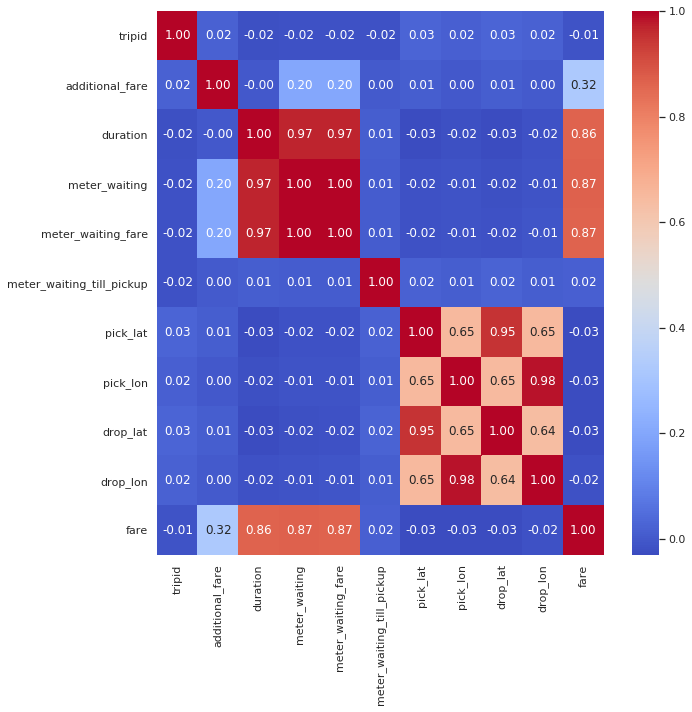

In [16]:
plt.figure(figsize=[10,10])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [17]:
dataset["fare"] = dataset["fare"].fillna(dataset["fare"].median())
dataset["additional_fare"] = dataset["additional_fare"].fillna(dataset["additional_fare"].median())
dataset["duration"] = dataset["duration"].fillna(dataset["duration"].median())
dataset["meter_waiting"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
dataset["meter_waiting_fare"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
dataset["meter_waiting_till_pickup"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())

In [18]:
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

tripid                          0
additional_fare                 0
duration                        0
meter_waiting                   0
meter_waiting_fare              0
meter_waiting_till_pickup       0
pickup_time                     0
drop_time                       0
pick_lat                        0
pick_lon                        0
drop_lat                        0
drop_lon                        0
fare                            0
label                        8576
dtype: int64

In [19]:
dataset.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,56.0,56.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,47.0,47.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,80.0,80.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,271.0,271.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,10.5,1019.0,123.0,123.0,123.0,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [20]:
dataset.drop(labels = ["tripid"], axis = 1, inplace = True)

In [21]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [22]:
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     #all_data[feat] += 1
#     dataset[feat] = boxcox1p(dataset[feat], lam)

In [23]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [24]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,56.0,56.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,47.0,47.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,80.0,80.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,271.0,271.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,10.5,1019.0,123.0,123.0,123.0,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [25]:
dataset.drop(labels = ["pickup_time"], axis = 1, inplace = True)
dataset.drop(labels = ["drop_time"], axis = 1, inplace = True)

In [26]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,56.0,56.0,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,47.0,47.0,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,80.0,80.0,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,271.0,271.0,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,10.5,1019.0,123.0,123.0,123.0,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [27]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["label"],axis = 1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15958 entries, 0 to 15957
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            15958 non-null  float64
 1   duration                   15958 non-null  float64
 2   meter_waiting              15958 non-null  float64
 3   meter_waiting_fare         15958 non-null  float64
 4   meter_waiting_till_pickup  15958 non-null  float64
 5   pick_lat                   15958 non-null  float64
 6   pick_lon                   15958 non-null  float64
 7   drop_lat                   15958 non-null  float64
 8   drop_lon                   15958 non-null  float64
 9   fare                       15958 non-null  float64
 10  label                      15958 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.3+ MB


In [29]:
train["label"] = train["label"].map({"correct": 1, "incorrect":0})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15958 entries, 0 to 15957
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            15958 non-null  float64
 1   duration                   15958 non-null  float64
 2   meter_waiting              15958 non-null  float64
 3   meter_waiting_fare         15958 non-null  float64
 4   meter_waiting_till_pickup  15958 non-null  float64
 5   pick_lat                   15958 non-null  float64
 6   pick_lon                   15958 non-null  float64
 7   drop_lat                   15958 non-null  float64
 8   drop_lon                   15958 non-null  float64
 9   fare                       15958 non-null  float64
 10  label                      15958 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.3 MB


In [31]:
test.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
15958,10.5,924.0,42.0,42.0,42.0,6.83454,79.8750,6.77490,79.8840,289.27
15959,10.5,4249.0,20.0,20.0,20.0,6.91168,79.8723,6.55091,79.9706,1912.70
15960,10.5,1552.0,255.0,255.0,255.0,6.92145,79.8478,6.90539,79.8989,394.00
15961,10.5,462.0,16.0,16.0,16.0,6.77433,79.9416,6.80401,79.9407,154.32
15962,10.5,814.0,392.0,392.0,392.0,6.97968,79.9130,6.98875,79.8914,147.47


In [32]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

In [34]:
X_train

array([[-0.03158342, -0.10882216, -0.07058409, ..., -0.37558025,
        -0.41054167, -0.07493188],
       [-0.03158342, -0.11403771, -0.07167829, ..., -0.30443872,
        -0.34370821, -0.19288387],
       [-0.03158342, -0.07813531, -0.06766621, ..., -0.14783187,
        -0.23725205, -0.02395553],
       ...,
       [-0.03158342, -0.17807982, -0.07629826, ...,  0.97529029,
        -0.29883431, -0.39088111],
       [-0.03158342, -0.10591115, -0.06341097, ..., -0.15431168,
        -0.30217598, -0.29792902],
       [-0.03158342, -0.17820111, -0.07483932, ..., -0.34195343,
        -0.12840899, -0.35447176]])

In [35]:
kfold = StratifiedKFold(n_splits=10)

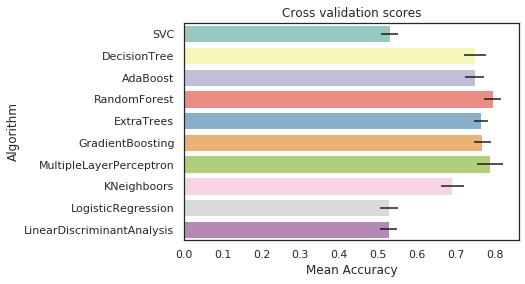

In [36]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "f1_macro", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [37]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.529772,0.021944,SVC
1,0.749762,0.027749,DecisionTree
2,0.749063,0.023880,AdaBoost
3,0.795381,0.022766,RandomForest
4,0.765332,0.019205,ExtraTrees
5,0.769001,0.022878,GradientBoosting
6,0.788529,0.032986,MultipleLayerPerceptron
7,0.691811,0.030427,KNeighboors
8,0.528682,0.023360,LogisticRegression
9,0.527954,0.022197,LinearDiscriminantAnalysis


In [38]:
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1)

scores = cross_val_score(random_forest, X_train, Y_train, cv=10, scoring = "f1_macro")

scores

array([0.84101134, 0.79558926, 0.74898945, 0.76942147, 0.80324993,
       0.77537132, 0.80918433, 0.77567354, 0.77611305, 0.7865996 ])

In [39]:
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(test)

In [40]:
# from sklearn.metrics import f1_score
# from sklearn.model_selection import cross_val_predict
# predictions = cross_val_predict(random_forest, X_train, Y_train, cv=10)
# f1_score(Y_train, predictions)

In [41]:
IDtest.head()

0    213284604
1    213286352
2    213293973
3    213294622
4    213298687
Name: tripid, dtype: int64

In [42]:
Y_prediction

array([1, 1, 1, ..., 1, 1, 1])

In [43]:
test_Survived = pd.Series(Y_prediction, name="prediction")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("submission.csv",index=False)

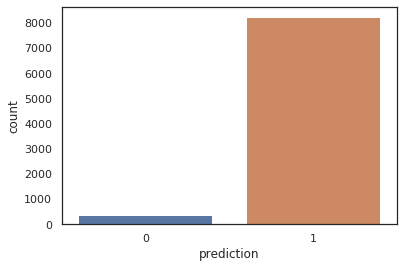

In [44]:
sns.countplot(x="prediction",data=results)

In [45]:
results.count().values

array([8576, 8576])